In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Imports & Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

np.random.seed(42)

Load Required Dataset

In [3]:
data = pd.read_csv(
    '/content/drive/MyDrive/Coffee/Dev/C2/price prediction/Data/coffee_price_simulation/coffee_price_monthly_dataset_CORRECTED.csv'
)

data.head()

,year,month,yield_source,predicted_yield_kg,global_price_usd_kg,usd_lkr_rate,demand_index,local_coffee_price_lkr_per_kg
0,2023.0,1.0,historical,573.95,3.504190,365.0,1.12,1565.97
1,2023.0,2.0,historical,667.74,3.996257,362.0,0.99,1345.70
2,2023.0,3.0,historical,684.29,3.888009,324.0,1.03,1189.67
3,2023.0,4.0,historical,590.14,4.142765,320.0,1.06,1494.00
4,2023.0,5.0,historical,720.92,4.060391,290.0,0.99,1014.55


Add Seasonality & Climate Features

In [4]:
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

Generate DEMAND INDEX

Economic logic:

Higher local price → demand ↓

Higher global price → export demand ↑

Weaker LKR (higher USD/LKR) → export demand ↑

Festive months → demand ↑

In [5]:
def generate_demand_index(row):
    # Base seasonal demand
    if row['month'] in [11, 12, 1]:
        seasonal = 1.1
    elif row['month'] in [6, 7]:
        seasonal = 0.95
    else:
        seasonal = 1.0

    # Price elasticity (local)
    price_effect = np.clip(
        3000 / row['local_coffee_price_lkr_per_kg'],
        0.85,
        1.15
    )

    # Export attractiveness
    export_effect = np.clip(
        (row['global_price_usd_kg'] * row['usd_lkr_rate']) / 1500,
        0.9,
        1.2
    )

    noise = np.random.normal(0, 0.03)

    demand = seasonal * price_effect * export_effect + noise
    return round(np.clip(demand, 0.8, 1.2), 2)

data['coffee_demand_index'] = data.apply(
    generate_demand_index, axis=1
)


Inspect Demand Index Behavior

In [6]:
data[['year', 'month', 'coffee_demand_index']].head()

data['coffee_demand_index'].describe()


,coffee_demand_index
count,36.000000
mean,1.056389
std,0.065166
min,0.960000
25%,1.000000
50%,1.050000
75%,1.100000
max,1.200000


Prepare Training Data

In [7]:
TARGET = 'coffee_demand_index'

FEATURES = [
    'local_coffee_price_lkr_per_kg',
    'global_price_usd_kg',
    'usd_lkr_rate',
    'month_sin',
    'month_cos'
]

X = data[FEATURES]
y = data[TARGET]


Train / Validation Split (Time-Safe)

In [8]:
split_idx = int(len(data) * 0.75)

X_train, X_val = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_val = y.iloc[:split_idx], y.iloc[split_idx:]


Train Demand Model (Ridge Regression)

In [9]:
demand_model = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0))
])

demand_model.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge())])

Validate Demand Behavior

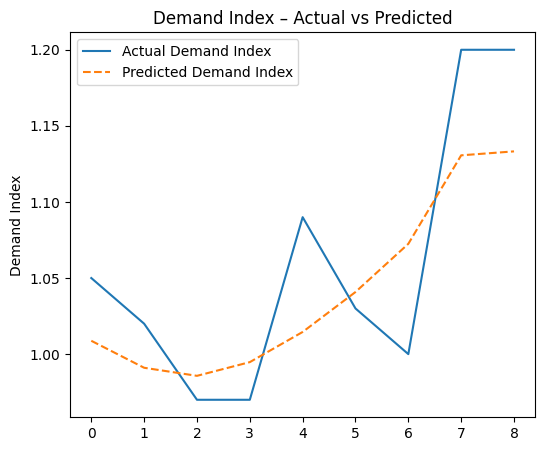

In [10]:
y_pred = demand_model.predict(X_val)

plt.figure(figsize=(6, 5))
plt.plot(y_val.values, label='Actual Demand Index')
plt.plot(y_pred, label='Predicted Demand Index', linestyle='--')
plt.legend()
plt.title('Demand Index – Actual vs Predicted')
plt.ylabel('Demand Index')
plt.show()

Elasticity Interpretation

In [11]:
coefficients = demand_model.named_steps['ridge'].coef_

elasticity_df = pd.DataFrame({
    'feature': FEATURES,
    'coefficient': coefficients
}).sort_values(by='coefficient', ascending=False)

elasticity_df

,feature,coefficient
4,month_cos,0.035513
1,global_price_usd_kg,0.010835
2,usd_lkr_rate,0.006162
0,local_coffee_price_lkr_per_kg,-0.001220
3,month_sin,-0.002067


Save Demand Model

In [12]:
import joblib

joblib.dump(
    demand_model,
    '/content/drive/MyDrive/Coffee/Dev/C2/demand prediction/coffee_demand_model.pkl'
)

print("Coffee demand model saved")

Coffee demand model saved


Add Demand Predictions to Dataset

In [13]:
data['predicted_demand_index'] = demand_model.predict(X).round(2)

data[['year', 'month', 'predicted_demand_index']].head()

,year,month,predicted_demand_index
0,2023.0,1.0,1.12
1,2023.0,2.0,1.10
2,2023.0,3.0,1.06
3,2023.0,4.0,1.04
4,2023.0,5.0,1.01


Save Demand Predictions

In [14]:
data.to_csv(
    '/content/drive/MyDrive/Coffee/Dev/C2/demand prediction/coffee_demand_predictions.csv',
    index=False
)

print("Demand prediction dataset saved")

Demand prediction dataset saved
